# Portfolio Asset Clustering Project (Canary Group)

## Dataset Preparation and Feature Engineering

### Import Libraries and Initialize Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MiniBatchKMeans, Birch   
from sklearn.mixture import GaussianMixture

# Metrics and Validation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy import stats

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

### Apply Stratified Sampling to Select Tickers from Different Sectors (NYSE)

In [2]:
df_strata = pd.read_csv('companies.csv')
df_strata = df_strata.groupby('sector', group_keys=False).apply(lambda x: x.sample(frac=0.10))
tickers = df_strata['ticker'].tolist()
print('Number of tickers: ', len(tickers))
#write list to file in json format
with open('sampled_tickers.json', 'w') as f:
    json.dump(tickers, f)

#write list to csv file in single column
df_tickers = pd.DataFrame(tickers, columns=['ticker'])
df_tickers.to_csv('sampled_tickers.csv', index=False)


Number of tickers:  245


### Load Data

In [3]:
# Load data for 2Y (2023-2025)
#df = pd.read_excel('sp500_stock_data.xlsx', sheet_name='Stock_Data')
#df = pd.read_excel('egx100_stock_data.xlsx', sheet_name='Stock_Data')
#df = pd.read_excel('NY1720_stock_data.xlsx', sheet_name='Stock_Data')
df = pd.read_excel('NY165_stock_data.xlsx', sheet_name='Stock_Data')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])

print(f"Unique stocks: {df['Ticker'].nunique()}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Trading days: {df['Date'].nunique()}")


Unique stocks: 165
Date range: 2023-12-01 to 2025-11-28
Trading days: 500


### Feature calculation functions

In [4]:
def calculate_advanced_features(group):
    """Calculate comprehensive features for clustering"""
    
    features = {}
    returns = group['Daily_Return'].dropna()
    prices = group['Close']
    
    if len(returns) < 126:  # At least 6 months
        return pd.Series(features)
    
    # === FEATURE 1-3: RETURNS (annualized) ===
    features['return_mean'] = returns.mean() * 252
    features['return_total'] = (prices.iloc[-1] / prices.iloc[0] - 1) if len(prices) > 0 else 0
    features['return_6m'] = (prices.iloc[-1] / prices.iloc[-min(126, len(prices))] - 1) if len(prices) >= 126 else 0
    
    # === FEATURE 4-6: VOLATILITY ===
    features['volatility'] = returns.std() * np.sqrt(252)
    features['downside_vol'] = returns[returns < 0].std() * np.sqrt(252) if (returns < 0).any() else 0
    vol_rolling = returns.rolling(20).std() * np.sqrt(252)
    features['vol_stability'] = vol_rolling.std() / vol_rolling.mean() if vol_rolling.mean() > 0 else 0
    
    # === FEATURE 7-8: RISK-ADJUSTED ===
    features['sharpe'] = features['return_mean'] / features['volatility'] if features['volatility'] > 0 else 0
    features['sortino'] = features['return_mean'] / features['downside_vol'] if features['downside_vol'] > 0 else 0
    
    # === FEATURE 9: TAIL RISK ===
    features['var_95'] = abs(returns.quantile(0.05))
    
    # === FEATURE 10: DISTRIBUTION ===
    features['skewness'] = returns.skew()
    
    # === FEATURE 11-12: LIQUIDITY ===
    if 'Volume' in group.columns:
        volume = group['Volume']
        features['avg_volume'] = np.log1p(volume.mean())  # Log transform
        features['volume_stability'] = volume.std() / volume.mean() if volume.mean() > 0 else 0

    # === FEATURE 13-14: Technical Indicators ===
    features['rsi'] = 100 - (100 / (1 + (returns[returns > 0].mean() / abs(returns[returns < 0].mean())))) if abs(returns[returns < 0].mean()) > 0 else 100
    features['macd'] = prices.ewm(span=12, adjust=False).mean().iloc[-1] - prices.ewm(span=26, adjust=False).mean().iloc[-1]

    return pd.Series(features)

# Calculate features for each stock
stock_features = df.groupby('Ticker').apply(calculate_advanced_features)

# If the result is a Series with a MultiIndex (Ticker, Feature), unstack it to get a DataFrame.
if isinstance(stock_features, pd.Series) or isinstance(stock_features.index, pd.MultiIndex):
    stock_features = stock_features.unstack()

if 'company' in df.columns:
    companies = df.groupby('Ticker')['company'].first()
    stock_features = stock_features.join(companies)

if 'sector' in df.columns:
    sectors = df.groupby('Ticker')['sector'].first()
    stock_features = stock_features.join(sectors)

if 'industry' in df.columns:
    industries = df.groupby('Ticker')['industry'].first()
    stock_features = stock_features.join(industries)

print(f"\nFeatures calculated for {len(stock_features)} stocks")
print(f"Total features: {stock_features.select_dtypes(include=[np.number]).shape[1]}")

stock_features.to_excel('01_stocks_latest_features.xlsx', index=True)
stock_features.to_csv('01_stocks_latest_features.csv', index=True)


Features calculated for 163 stocks
Total features: 14


In [5]:
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")

# Show feature summary
print("\nFeatures by category:")
print(f"  Returns: {len([c for c in stock_features.columns if 'return' in c.lower()])}")
print(f"  Risk: {len([c for c in stock_features.columns if 'var' in c.lower() or 'vol' in c.lower() or 'drawdown' in c.lower() or 'sharpe' in c.lower()])}")
print(f"  Technical: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['sma', 'ema', 'rsi', 'macd'])])}")
print(f"  Statistical: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['skew', 'kurt', 'autocorr'])])}")
print(f"  Liquidity: {len([c for c in stock_features.columns if 'volume' in c.lower() or 'liquidity' in c.lower()])}")
print(f"  Tail Risk: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['tail', 'shortfall', 'gain_to_pain', 'win_rate'])])}")


SUMMARY STATISTICS

Features by category:
  Returns: 3
  Risk: 7
  Technical: 2
  Statistical: 1
  Liquidity: 2
  Tail Risk: 0


### LOAD AND EXPLORE DATA

In [6]:
stock_features = pd.read_excel('01_stocks_latest_features.xlsx', index_col=0)
print(f"\nDataset Shape: {stock_features.shape}")

# Separate numerical and categorical features
numerical_features = stock_features.select_dtypes(include=[np.number])
categorical_features = stock_features.select_dtypes(exclude=[np.number])

print(f"\nNumerical features: {len(numerical_features.columns)}")
print(f"Categorical features: {len(categorical_features.columns)}")

# Check for missing values
missing_vals = stock_features.isnull().sum()
missing_per = ((stock_features.isnull().sum() / len(stock_features)) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_vals,'Percentage (%)': missing_per}) # Combine into a DataFrame for better visualization
missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)


Dataset Shape: (163, 16)

Numerical features: 14
Categorical features: 2


,Missing Count,Percentage (%)


## Feature Engineering and Dimensionality Reduction

### Feature Preprocessing and Scaling

In [7]:
print(f"\n{'='*80}")
print("PREPROCESSING PIPELINE")
print(f"{'='*80}\n")

features_processed = numerical_features.copy()
preprocessing_stats = {'original_features': features_processed.shape[1]}

# STEP 1: Handle Missing Values with KNN Imputer
missing_count = features_processed.isnull().sum().sum()
if missing_count > 0:
    print(f"[1] Imputing {missing_count} missing values using KNN (k=5)...")
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    features_processed = pd.DataFrame(
        imputer.fit_transform(features_processed),
        index=features_processed.index,
        columns=features_processed.columns
    )
else:
    print("[1] No missing values found")

# STEP 2: Handle Infinite Values
inf_count = np.isinf(features_processed).sum().sum()
if inf_count > 0:
    print(f"[2] Handling {inf_count} infinite values...")
    features_processed = features_processed.replace([np.inf, -np.inf], np.nan)
    features_processed = features_processed.fillna(features_processed.median())
else:
    print("[2] No infinite values found")

# STEP 3: Winsorize Outliers
print("\n[3] Clipping outliers (Winsorization 2.5%)...")
outliers_clipped = 0
for col in features_processed.columns:
    q025 = features_processed[col].quantile(0.025)
    q975 = features_processed[col].quantile(0.975)
    before = ((features_processed[col] < q025) | (features_processed[col] > q975)).sum()
    features_processed[col] = winsorize(features_processed[col], limits=[0.025, 0.025])
    outliers_clipped += before
print(f"    → Clipped {outliers_clipped} outlier values")
    
# STEP 4: Remove Highly Correlated Features
print("\n[4] Removing highly correlated features (>0.85)...")
corr_matrix = features_processed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

if to_drop:
    print(f"    → Dropping: {to_drop}")
    df_selected = features_processed.drop(columns=to_drop)
else:
    print(f"    → No highly correlated features found")
    df_selected = features_processed

# STEP 5: Scaling with RobustScaler
print("\n[5] Scaling features (RobustScaler)...")
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df_selected)
features_scaled = pd.DataFrame(features_scaled, columns=df_selected.columns, index=df_selected.index)

print(f"\n{'='*80}")
print("PREPROCESSING SUMMARY")
print(f"{'='*80}")
print(f"Original features:        {preprocessing_stats['original_features']}")
print(f"Outliers winsorized:      {outliers_clipped}")
print(f"Final features:           {len(features_scaled.columns)}")
print(f"Stocks in analysis:       {len(features_scaled)}")

features_scaled.to_csv('02_features_preprocessed.csv')



PREPROCESSING PIPELINE

[1] No missing values found
[2] No infinite values found

[3] Clipping outliers (Winsorization 2.5%)...
    → Clipped 140 outlier values

[4] Removing highly correlated features (>0.85)...
    → Dropping: ['return_total', 'sharpe', 'sortino', 'var_95', 'volatility']

[5] Scaling features (RobustScaler)...

PREPROCESSING SUMMARY
Original features:        14
Outliers winsorized:      140
Final features:           9
Stocks in analysis:       163


### Keep only Descriminative features after Preprocessing

In [8]:
# Use preliminary clustering to identify discriminative features
preliminary_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
preliminary_labels = preliminary_kmeans.fit_predict(features_scaled)

# Calculate feature importance based on cluster separation
feature_importance = {}
for col in features_scaled.columns:
    # Calculate variance between clusters vs within clusters
    between_var = 0
    within_var = 0
    overall_mean = features_scaled[col].mean()
    
    for cluster in range(3):
        cluster_data = features_scaled[preliminary_labels == cluster][col]
        cluster_mean = cluster_data.mean()
        cluster_size = len(cluster_data)
        
        between_var += cluster_size * (cluster_mean - overall_mean)**2
        within_var += ((cluster_data - cluster_mean)**2).sum()
    
    # F-statistic
    f_stat = (between_var / 2) / (within_var / (len(features_scaled) - 3)) if within_var > 0 else 0
    feature_importance[col] = f_stat

# Rank features
importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values('Importance', ascending=False)

print('\nFeature Importance Ranking:')
for idx, row in importance_df.iterrows():
    print(f"  {row['Feature']:20s}: {row['Importance']:.3f}")

# Keep top 8-10 features
n_features_to_keep = min(10, len(importance_df))
top_features = importance_df.head(n_features_to_keep)['Feature'].tolist()

features_selected = features_scaled[top_features]

print(f'\n✓ Selected top {len(top_features)} features:')
print(f'  {top_features}')
features_selected.to_csv('04_features_selected.csv')


Feature Importance Ranking:
  volume_stability    : 248.898
  macd                : 101.984
  downside_vol        : 22.875
  vol_stability       : 13.767
  rsi                 : 12.138
  skewness            : 9.738
  return_6m           : 4.049
  return_mean         : 2.462
  avg_volume          : 1.652

✓ Selected top 9 features:
  ['volume_stability', 'macd', 'downside_vol', 'vol_stability', 'rsi', 'skewness', 'return_6m', 'return_mean', 'avg_volume']


### PCA for Dimensionality Reduction

In [9]:
best_score = -1
best_k = 0
best_pca = 0
best_labels = None
best_pca_data = None

results_log = []

# Try different PCA components (2 to min(7, n_features))
n_features = features_scaled.shape[1]
pca_options = list(range(2, min(7, n_features) + 1))

for n_components in pca_options:
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(features_scaled)
    
    # Try different K (3 to 8)
    for k in range(3, 9):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
        labels = kmeans.fit_predict(X_pca)
        
        # Calculate metrics
        inertia_score = kmeans.inertia_
        sil_score = silhouette_score(X_pca, labels)
        cal_score = calinski_harabasz_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        
        # Balance score
        sizes = pd.Series(labels).value_counts().values
        balance = sizes.min() / sizes.max()
        
        results_log.append({
            'pca': n_components,
            'k': k,
            'inertia': inertia_score,
            'silhouette': sil_score,
            'calinski': cal_score,
            'davies_bouldin': db_score,
            'balance': balance
        })
        
        # Update best by prioritizing silhouette
        if sil_score > best_score:
            best_score = sil_score
            best_k = k
            best_pca = n_components
            best_labels = labels
            best_pca_data = X_pca
            best_pca_model = pca

results_df = pd.DataFrame(results_log).sort_values('silhouette', ascending=False)
print("\nTop 10 Combinations:")
print("="*90)
print(f"{'PCA':<5} {'K':<4} {'Silhouette':<12} {'Balance':<10} {'Calinski-H':<12} {'Davies-B':<12}")
print("="*90)
for i, row in results_df.head(10).iterrows():
    marker = " ← SELECTED" if (row['pca'] == best_pca and row['k'] == best_k) else ""
    print(f"{row['pca']:<5.0f} {row['k']:<4.0f} {row['silhouette']:<12.4f} {row['balance']:<10.3f} "
            f"{row['calinski']:<12.2f} {row['davies_bouldin']:<12.4f}{marker}")

print(f"\n🏆 BEST RESULT:")
print(f"Silhouette Score: {best_score:.4f}")
print(f"Number of Clusters (k): {best_k}")
print(f"PCA Components: {best_pca}")
print(f"Variance Explained: {best_pca_model.explained_variance_ratio_.sum()*100:.2f}%")

final_df = features_processed.loc[features_processed.index].copy()
final_df['Cluster'] = best_labels

print("\nCluster Sizes:")
print(final_df['Cluster'].value_counts().sort_index())

final_df.to_csv('03_features_pca.csv')



Top 10 Combinations:
PCA   K    Silhouette   Balance    Calinski-H   Davies-B    
2     3    0.6612       0.087      152.95       0.5534       ← SELECTED
2     4    0.5977       0.098      191.50       0.5751      
3     3    0.5936       0.087      113.53       0.6708      
2     5    0.5678       0.052      222.67       0.5649      
4     3    0.5631       0.087      99.24        0.7290      
5     3    0.5423       0.087      89.83        0.7728      
2     6    0.5397       0.060      276.44       0.5518      
3     4    0.5282       0.069      122.46       0.6436      
6     3    0.5250       0.087      84.55        0.7978      
2     8    0.5184       0.071      343.90       0.5435      

🏆 BEST RESULT:
Silhouette Score: 0.6612
Number of Clusters (k): 3
PCA Components: 2
Variance Explained: 74.69%

Cluster Sizes:
Cluster
0    138
1     13
2     12
Name: count, dtype: int64


### Visualize Scoring Metrics for different PCA and K values

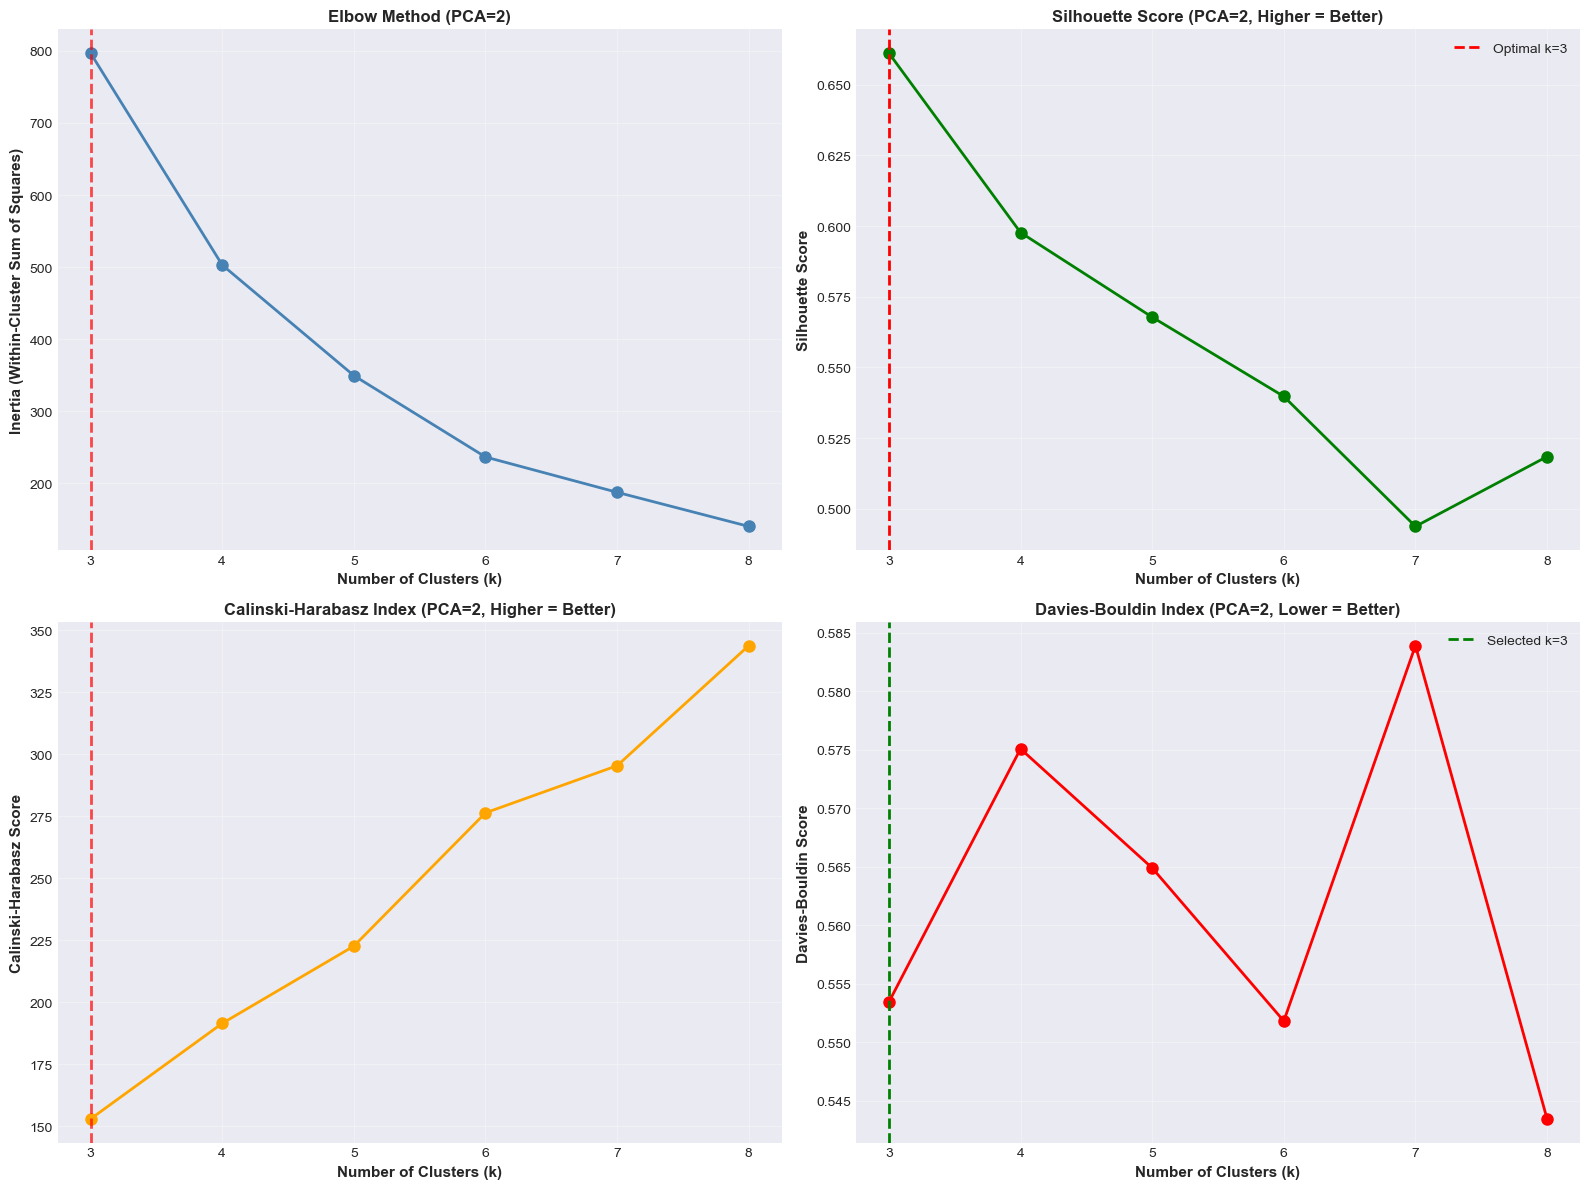


All metrics for PCA=2 components across k=3 to 8 clusters


In [10]:
# Prepare data for visualization - filter by best PCA components
best_pca_results = results_df[results_df['pca'] == best_pca].sort_values('k')

k_values = best_pca_results['k'].values
inertia_values = best_pca_results['inertia'].values
silhouette_values = best_pca_results['silhouette'].values
calinski_values = best_pca_results['calinski'].values
davies_bouldin_values = best_pca_results['davies_bouldin'].values

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow plot
axes[0, 0].plot(k_values, inertia_values, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].axvline(x=best_k, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Elbow Method (PCA={best_pca})', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_values)

# Silhouette scores
axes[0, 1].plot(k_values, silhouette_values, 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].axvline(x=best_k, color='r', linestyle='--', linewidth=2, label=f'Optimal k={best_k}')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Silhouette Score (PCA={best_pca}, Higher = Better)', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_values)

# Calinski-Harabasz
axes[1, 0].plot(k_values, calinski_values, 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].axvline(x=best_k, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'Calinski-Harabasz Index (PCA={best_pca}, Higher = Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_values)

# Davies-Bouldin
axes[1, 1].plot(k_values, davies_bouldin_values, 'o-', linewidth=2, markersize=8, color='red')
axes[1, 1].axvline(x=best_k, color='g', linestyle='--', linewidth=2, label=f'Selected k={best_k}')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Davies-Bouldin Index (PCA={best_pca}, Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values)

plt.tight_layout()
plt.savefig('05_optimal_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll metrics for PCA={best_pca} components across k={k_values.min()} to {k_values.max()} clusters")

### Optimal Number of Clusters and Algorithm Selection

In [11]:
clustering_results = {}

# Use PCA data for fair comparison
features_scaled = best_pca_data

# Define algorithms to test
algorithms = {
    'K-Means': KMeans(n_clusters=best_k, random_state=42, n_init=20),
    'Mini-Batch K-Means': MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init=20),
    'Hierarchical (Ward)': AgglomerativeClustering(n_clusters=best_k, linkage='ward'),
    'Hierarchical (Average)': AgglomerativeClustering(n_clusters=best_k, linkage='average'),
    'Gaussian Mixture': GaussianMixture(n_components=best_k, random_state=42, n_init=10),
    'Spectral': SpectralClustering(n_clusters=best_k, random_state=42, affinity='nearest_neighbors'),
    'DBSCAN': DBSCAN(eps=2.5,min_samples=3),
    'Birch': Birch(n_clusters=best_k)
}

for name, model in algorithms.items():
    try:
        labels = model.fit_predict(features_scaled)
        
        sil_score = silhouette_score(features_scaled, labels)
        cal_score = calinski_harabasz_score(features_scaled, labels)
        db_score = davies_bouldin_score(features_scaled, labels)
        
        sizes = pd.Series(labels).value_counts().values
        balance = sizes.min() / sizes.max()
        
        clustering_results[name] = {
            'labels': labels,
            'silhouette': sil_score,
            'calinski': cal_score,
            'davies_bouldin': db_score,
            'balance': balance
        }
        
    except Exception as e:
        print(f"⚠ {name} failed: {str(e)[:60]}")
        continue

# Create comparison table
comparison_df = pd.DataFrame({
    'Algorithm': list(clustering_results.keys()),
    'Silhouette': [v['silhouette'] for v in clustering_results.values()],
    'Balance': [v['balance'] for v in clustering_results.values()],
    'Calinski-H': [v['calinski'] for v in clustering_results.values()],
    'Davies-B': [v['davies_bouldin'] for v in clustering_results.values()]
}).sort_values('Silhouette', ascending=False)

print("\nALGORITHM COMPARISON RESULTS")
print("="*100)
print(f"{'Algorithm':<25} {'Silhouette':<15} {'Balance':<12} {'Calinski-H':<15} {'Davies-B':<12}")
print("="*100)

for idx, row in comparison_df.iterrows():
    marker = " ← BEST" if idx == comparison_df.index[0] else ""
    print(f"{row['Algorithm']:<25} {row['Silhouette']:<15.4f} {row['Balance']:<12.3f} "
            f"{row['Calinski-H']:<15.2f} {row['Davies-B']:<12.4f}{marker}")

best_algorithm = comparison_df.iloc[0]['Algorithm']
best_sil = comparison_df.iloc[0]['Silhouette']
best_labels = clustering_results[best_algorithm]['labels']

print(f"\nBest Algorithm: {best_algorithm}")
print(f"Silhouette Score: {best_sil:.4f}")

numerical_features['Cluster_Best_Algorithm'] = best_labels

# Cluster distribution
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster, count in cluster_counts.items():
    cluster_label = f"Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"  {cluster_label}: {count:3d} stocks ({count/len(best_labels)*100:5.1f}%)")


ALGORITHM COMPARISON RESULTS
Algorithm                 Silhouette      Balance      Calinski-H      Davies-B    
DBSCAN                    0.7245          0.038        85.42           0.2553       ← BEST
Hierarchical (Average)    0.7010          0.040        132.70          0.3207      
Birch                     0.7010          0.040        132.70          0.3207      
Hierarchical (Ward)       0.7010          0.040        132.70          0.3207      
K-Means                   0.6612          0.087        152.95          0.5534      
Mini-Batch K-Means        0.6612          0.087        152.95          0.5534      
Spectral                  0.3358          0.279        56.88           1.0292      
Gaussian Mixture          0.3071          0.230        34.84           3.6520      

Best Algorithm: DBSCAN
Silhouette Score: 0.7245

Cluster Distribution:
  Cluster 0: 157 stocks ( 96.3%)
  Cluster 1:   6 stocks (  3.7%)


### Compare Clustering Algorithms

In [ ]:
print("\n" + "=" * 80)
print("CLUSTERING ALGORITHM COMPARISON")
print("=" * 80)

clustering_results = {}

# K-Means
print("\n[1] K-Means Clustering")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(features_scaled)
clustering_results['K-Means'] = {
    'labels': labels_kmeans,
    'silhouette': silhouette_score(features_scaled, labels_kmeans),
    'calinski': calinski_harabasz_score(features_scaled, labels_kmeans),
    'davies_bouldin': davies_bouldin_score(features_scaled, labels_kmeans),
    'balance': pd.Series(labels_kmeans).value_counts().min() / pd.Series(labels_kmeans).value_counts().max()
}
print(f"   Silhouette: {clustering_results['K-Means']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['K-Means']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['K-Means']['davies_bouldin']:.4f}")
print(f"   Balance: {clustering_results['K-Means']['balance']:.4f}")

# Hierarchical (Ward)
print("\n[2] Hierarchical Clustering (Ward)")
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_hierarchical = hierarchical.fit_predict(features_scaled)
clustering_results['Hierarchical'] = {
    'labels': labels_hierarchical,
    'silhouette': silhouette_score(features_scaled, labels_hierarchical),
    'calinski': calinski_harabasz_score(features_scaled, labels_hierarchical),
    'davies_bouldin': davies_bouldin_score(features_scaled, labels_hierarchical),
    'balance': pd.Series(labels_hierarchical).value_counts().min() / pd.Series(labels_hierarchical).value_counts().max()
}
print(f"   Silhouette: {clustering_results['Hierarchical']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['Hierarchical']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['Hierarchical']['davies_bouldin']:.4f}")
print(f"   Balance: {clustering_results['Hierarchical']['balance']:.4f}")

# Select best algorithm
best_algorithm = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])[0]
best_labels = clustering_results[best_algorithm]['labels']
best_score = clustering_results[best_algorithm]['silhouette']

print("\n" + "=" * 80)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Algorithm': list(clustering_results.keys()),
    'Silhouette': [v['silhouette'] for v in clustering_results.values()],
    'Calinski-Harabasz': [v['calinski'] for v in clustering_results.values()],
    'Davies-Bouldin': [v['davies_bouldin'] for v in clustering_results.values()]
}).sort_values('Silhouette', ascending=False)
print(comparison_df.to_string(index=False))

print(f"\n✓ BEST ALGORITHM: {best_algorithm}")
print(f"   Silhouette Score: {clustering_results[best_algorithm]['silhouette']:.4f}")


# Add cluster labels to features
numerical_features['Cluster'] = best_labels


# Cluster distribution
print("\nCluster Distribution:")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(best_labels) * 100
    print(f"   Cluster {cluster}: {count} stocks ({pct:.1f}%)")



CLUSTERING ALGORITHM COMPARISON

[1] K-Means Clustering
   Silhouette: 0.6612
   Calinski-Harabasz: 152.95
   Davies-Bouldin: 0.5534
   Balance: 0.0870

[2] Hierarchical Clustering (Ward)
   Silhouette: 0.7010
   Calinski-Harabasz: 132.70
   Davies-Bouldin: 0.3207
   Balance: 0.0403

ALGORITHM COMPARISON SUMMARY
   Algorithm  Silhouette  Calinski-Harabasz  Davies-Bouldin
Hierarchical    0.700979         132.696004        0.320672
     K-Means    0.661160         152.945435        0.553435

✓ BEST ALGORITHM: Hierarchical
   Silhouette Score: 0.7010

Cluster Distribution:
   Cluster 0: 149 stocks (91.4%)
   Cluster 1: 6 stocks (3.7%)
   Cluster 2: 8 stocks (4.9%)


### Post Clustering Analysis

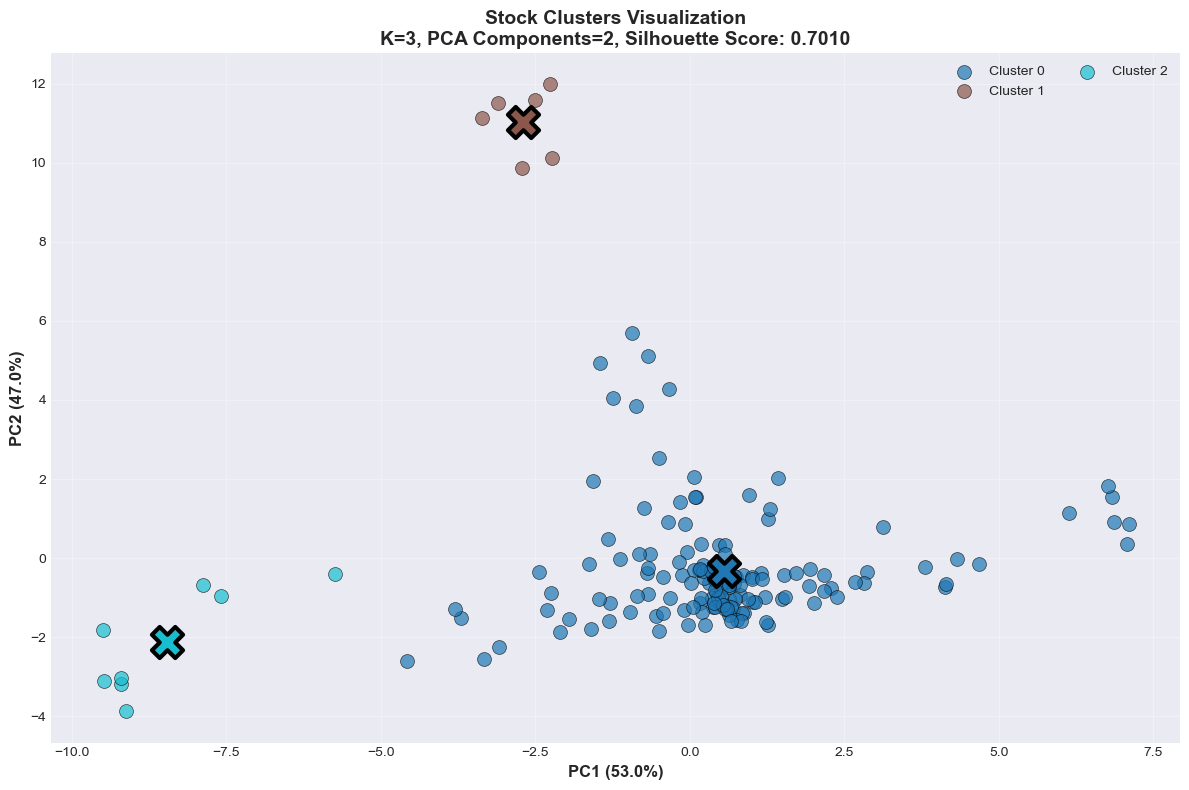

In [13]:
# Visualize clusters using the best PCA result (2D projection for visualization)
pca_viz = PCA(n_components=2, random_state=42)
features_pca_2d = pca_viz.fit_transform(features_scaled)

plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, best_k))

for cluster in range(best_k):
    mask = best_labels == cluster
    plt.scatter(features_pca_2d[mask, 0], features_pca_2d[mask, 1],
                c=[colors[cluster]], label=f'Cluster {cluster}',
                s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Centroid
    centroid = features_pca_2d[mask].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker='X', s=500,
                c=[colors[cluster]], edgecolors='black', linewidth=3, zorder=10)

plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
plt.title(f'Stock Clusters Visualization\nK={best_k}, PCA Components={best_pca}, Silhouette Score: {best_score:.4f}', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'06_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

### Cluster Analysis

In [14]:
for cluster in sorted(numerical_features['Cluster'].unique()):
    cluster_stocks = numerical_features[numerical_features['Cluster'] == cluster]
    
    print(f'\nCluster {cluster} ({len(cluster_stocks)} stocks, {len(cluster_stocks)/len(numerical_features)*100:.1f}%)')
    print('-'*70)
    
    numeric_cols = [col for col in cluster_stocks.columns if col != 'Cluster']
    
    if len(numeric_cols) > 0:
        cluster_means = cluster_stocks[numeric_cols].mean()
        overall_means = numerical_features[numeric_cols].mean()
        
        print('\nKey Characteristics (vs overall avg):')
        for col in numeric_cols[:8]:  # Show top 8
            val = cluster_means[col]
            overall = overall_means[col]
            diff = ((val / overall - 1) * 100) if overall != 0 else 0
            direction = '↑' if diff > 5 else '↓' if diff < -5 else '≈'
            print(f'  {col:20s}: {val:8.4f} {direction} {abs(diff):6.1f}%')



Cluster 0 (149 stocks, 91.4%)
----------------------------------------------------------------------

Key Characteristics (vs overall avg):
  avg_volume          :  13.3871 ≈    0.7%
  downside_vol        :   0.2321 ↓    5.3%
  macd                :   0.5531 ↓ 2660.9%
  return_6m           :   0.0989 ↑    5.0%
  return_mean         :   0.1064 ≈    4.5%
  return_total        :   0.1996 ↑    8.2%
  rsi                 :  49.9589 ≈    0.2%
  sharpe              :   0.3593 ≈    3.0%

Cluster 1 (6 stocks, 3.7%)
----------------------------------------------------------------------

Key Characteristics (vs overall avg):
  avg_volume          :  10.8275 ↓   18.6%
  downside_vol        :   0.5914 ↑  141.2%
  macd                :  -0.2395 ↑ 1008.7%
  return_6m           :   0.1207 ↑   28.1%
  return_mean         :  -0.0603 ↓  159.2%
  return_total        :  -0.3950 ↓  314.3%
  rsi                 :  53.3793 ↑    6.6%
  sharpe              :   0.0325 ↓   90.7%

Cluster 2 (8 stocks, 4.9%)
-----

### Portfolio Optimization and Business Intelligence Functions

In [15]:
# Business Intelligence Functions

def profile_clusters(features_df):
    """Calculate metrics for each cluster"""
    profiles = {}
    
    for cluster_id in sorted(features_df['Cluster'].unique()):
        cluster_data = features_df[features_df['Cluster'] == cluster_id]
        
        profiles[cluster_id] = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(features_df) * 100,
            'avg_return': cluster_data['return_mean'].mean(),
            'avg_volatility': cluster_data['volatility'].mean(),
            'avg_sharpe': cluster_data['sharpe'].mean(),
            'avg_sortino': cluster_data['sortino'].mean(),
            'avg_downside_vol': cluster_data['downside_vol'].mean(),
        }
    
    return profiles

def identify_cluster_archetype(cluster_id, profiles):
    """Identify business archetype based on metrics"""
    profile = profiles[cluster_id]
    
    # Calculate percentiles
    all_returns = [p['avg_return'] for p in profiles.values()]
    all_vols = [p['avg_volatility'] for p in profiles.values()]
    all_sharpes = [p['avg_sharpe'] for p in profiles.values()]
    
    return_pct = stats.percentileofscore(all_returns, profile['avg_return'])
    vol_pct = stats.percentileofscore(all_vols, profile['avg_volatility'])
    sharpe_pct = stats.percentileofscore(all_sharpes, profile['avg_sharpe'])
    
    # Decision tree
    if sharpe_pct >= 70 and return_pct >= 60:
        return {
            'name': '⭐ Star Performers',
            'description': 'High returns with excellent risk-adjusted performance',
            'strategy': 'OVERWEIGHT - Core portfolio holdings',
            'allocation_suggestion': '30-40%',
            'color': '#2ecc71',
            'risk_level': 'Medium',
            'characteristics': ['High Sharpe Ratio', 'Strong Returns', 'Optimal Risk-Return']
        }
    elif return_pct >= 60 and vol_pct >= 60:
        return {
            'name': '🚀 High Growth/High Risk',
            'description': 'Strong returns but with elevated volatility',
            'strategy': 'TACTICAL - Satellite positions for aggressive growth',
            'allocation_suggestion': '15-25%',
            'color': '#e74c3c',
            'risk_level': 'High',
            'characteristics': ['High Volatility', 'High Returns', 'Momentum Plays']
        }
    elif vol_pct <= 40 and return_pct >= 40:
        return {
            'name': '🛡️ Defensive Stable',
            'description': 'Moderate returns with low volatility',
            'strategy': 'CORE - Portfolio stability and downside protection',
            'allocation_suggestion': '25-35%',
            'color': '#3498db',
            'risk_level': 'Low',
            'characteristics': ['Low Volatility', 'Stable Returns', 'Capital Preservation']
        }
    elif return_pct <= 40 and vol_pct <= 40:
        return {
            'name': '😴 Underperformers',
            'description': 'Low returns with low volatility - cash-like',
            'strategy': 'UNDERWEIGHT - Consider rebalancing or exit',
            'allocation_suggestion': '5-10%',
            'color': '#95a5a6',
            'risk_level': 'Low',
            'characteristics': ['Low Returns', 'Low Volatility', 'Minimal Growth']
        }
    elif vol_pct >= 70:
        return {
            'name': '⚠️ High Volatility Speculative',
            'description': 'Extreme volatility regardless of returns',
            'strategy': 'AVOID/MINIMAL - High risk without commensurate returns',
            'allocation_suggestion': '0-5%',
            'color': '#e67e22',
            'risk_level': 'Very High',
            'characteristics': ['Extreme Volatility', 'Unpredictable', 'Speculative']
        }
    else:
        return {
            'name': '📊 Market Neutral',
            'description': 'Average performance across all metrics',
            'strategy': 'NEUTRAL - Market weight allocation',
            'allocation_suggestion': '15-20%',
            'color': '#9b59b6',
            'risk_level': 'Medium',
            'characteristics': ['Balanced Profile', 'Market-Like Returns', 'Diversification']
        }

# Portfolio Optimization Function
def suggest_optimal_allocation(risk_tolerance='moderate'):
    """
    Suggest portfolio allocation based on cluster archetypes and risk tolerance
    
    Args:
        risk_tolerance: 'conservative', 'moderate', or 'aggressive'

    Returns:
        Dict of archetype names to allocation percentages (0-1)
    """
    # Base allocation weights for moderate risk profile
    base_weights = {
        'Star Performers':           0.35,  # High Sharpe, strong returns
        'Defensive Stable':          0.30,  # Low volatility, stable
        'High Growth/High Risk':     0.20,  # High return, high volatility
        'Market Neutral':            0.10,  # Average performance
        'Underperformers':           0.05,  # Low return, low volatility
        'High Volatility Speculative': 0.00  # Exclude completely
    }
    
    # Risk tolerance adjustment multipliers
    if risk_tolerance == 'conservative':
        # Conservative: Prefer safety over growth
        adjustments = {
            'Defensive Stable':          1.3,  # +30% allocation
            'Star Performers':           1.1,  # +10% allocation
            'High Growth/High Risk':     0.5,  # -50% allocation (reduce risk)
            'Market Neutral':            1.0,  # No change
            'Underperformers':           0.3,  # -70% allocation
            'High Volatility Speculative': 0.0  # Exclude completely
        }
        
    elif risk_tolerance == 'aggressive':
        # Aggressive: Increase growth positions, reduce defensive holdings
        adjustments = {
            'Defensive Stable':          0.7,  # -30% allocation
            'Star Performers':           1.2,  # +20% allocation
            'High Growth/High Risk':     1.5,  # +50% allocation (seek growth)
            'Market Neutral':            0.8,  # -20% allocation
            'Underperformers':           0.0,  # Exclude completely
            'High Volatility Speculative': 0.0  # Exclude completely
        }
        
    else:  # moderate
        adjustments = base_weights
    
    # Apply the adjustment multipliers to base weights
    adjusted_weights = {
        archetype: base_weights[archetype] * adjustments[archetype] for archetype in base_weights.keys()
    }
    
    # Normalization to rescales them proportionally to sum to exactly 1.0
    total_weight = sum(adjusted_weights.values())
    normalized_weights = {
        archetype: weight / total_weight for archetype, weight in adjusted_weights.items()
    }
    
    return normalized_weights


### Business Analysis Per Cluster

In [16]:
def generate_business_report(features_df):
    """Generate comprehensive business intelligence report"""
    profiles = profile_clusters(features_df)
    
    report = {
        'executive_summary': {
            'total_stocks_analyzed': len(features_df),
            'number_of_clusters': len(profiles),
        },
        'cluster_details': {}
    }
    
    for cluster_id in sorted(profiles.keys()):
        archetype = identify_cluster_archetype(cluster_id, profiles)
        report['cluster_details'][cluster_id] = {
            'archetype': archetype,
            'profile': profiles[cluster_id],
            'stocks_count': profiles[cluster_id]['size']
        }
    
    return report

def print_business_report(report):
    """Print formatted business report"""
    print("" + "="*80)
    print("PORTFOLIO CLUSTERING - BUSINESS INTELLIGENCE REPORT")
    print("="*80)
    
    print(f"Executive Summary:")
    print(f"   • Total Stocks Analyzed: {report['executive_summary']['total_stocks_analyzed']}")
    print(f"   • Number of Clusters: {report['executive_summary']['number_of_clusters']}")
    print("" + "-"*80)
    
    for cluster_id, details in report['cluster_details'].items():
        archetype = details['archetype']
        profile = details['profile']
        
        print(f"{archetype['name']} (Cluster {cluster_id})")
        print("="*80)
        print(f"Description: {archetype['description']}")
        print(f"Strategy: {archetype['strategy']}")
        print(f"Suggested Allocation: {archetype['allocation_suggestion']}")
        print(f"Risk Level: {archetype['risk_level']}")
        
        print(f"Portfolio Metrics:")
        print(f"   • Size: {profile['size']} stocks ({profile['percentage']:.1f}% of portfolio)")
        print(f"   • Average Return: {profile['avg_return']:.4f}")
        print(f"   • Average Volatility: {profile['avg_volatility']:.4f}")
        print(f"   • Sharpe Ratio: {profile['avg_sharpe']:.4f}")
        print(f"   • Sortino Ratio: {profile['avg_sortino']:.4f}")
        
        print(f"Key Characteristics:")
        for char in archetype['characteristics']:
            print(f"   • {char}")
        print("" + "-"*80)

business_report = generate_business_report(numerical_features)
print_business_report(business_report)

# Store cluster archetypes for later use
cluster_archetypes = {
    cid: details['archetype'] 
    for cid, details in business_report['cluster_details'].items()
}

PORTFOLIO CLUSTERING - BUSINESS INTELLIGENCE REPORT
Executive Summary:
   • Total Stocks Analyzed: 163
   • Number of Clusters: 3
--------------------------------------------------------------------------------
🚀 High Growth/High Risk (Cluster 0)
Description: Strong returns but with elevated volatility
Strategy: TACTICAL - Satellite positions for aggressive growth
Suggested Allocation: 15-25%
Risk Level: High
Portfolio Metrics:
   • Size: 149 stocks (91.4% of portfolio)
   • Average Return: 0.1064
   • Average Volatility: 0.3256
   • Sharpe Ratio: 0.3593
   • Sortino Ratio: 0.5153
Key Characteristics:
   • High Volatility
   • High Returns
   • Momentum Plays
--------------------------------------------------------------------------------
⚠️ High Volatility Speculative (Cluster 1)
Description: Extreme volatility regardless of returns
Strategy: AVOID/MINIMAL - High risk without commensurate returns
Suggested Allocation: 0-5%
Risk Level: Very High
Portfolio Metrics:
   • Size: 6 stocks (

### Value at Risk (VaR) and Conditional VaR at 95% Confidence Level

In [17]:
# Calculate Value at Risk and Conditional VaR for each cluster
var_cvar_results = {}

for cluster in numerical_features['Cluster'].unique():
    cluster_data = numerical_features[numerical_features['Cluster'] == cluster]
    returns = cluster_data['return_mean'].values
    
    # VaR at 95% confidence
    var = np.percentile(returns, 5)
    
    # CVaR (average of returns below VaR)
    cvar = returns[returns <= var].mean() if len(returns[returns <= var]) > 0 else var
    
    var_cvar_results[cluster] = {
        'VaR': var,
        'CVaR': cvar,
        'stocks_at_risk': len(returns[returns <= var])
    }

# Convert to DataFrame and add cluster names
var_cvar_df = pd.DataFrame(var_cvar_results).T
var_cvar_df['Cluster_Name'] = [cluster_archetypes[idx]['name'] for idx in var_cvar_df.index]

print("\n" + "="*80)
print("VALUE AT RISK (VaR) AND CONDITIONAL VaR ANALYSIS")
print("="*80)
print("\nConfidence Level: 95%\n")
print(var_cvar_df)


VALUE AT RISK (VaR) AND CONDITIONAL VaR ANALYSIS

Confidence Level: 95%

        VaR      CVaR  stocks_at_risk                    Cluster_Name
0 -0.196976 -0.308796             8.0         🚀 High Growth/High Risk
2 -0.142905 -0.178025             1.0               ⭐ Star Performers
1 -1.520130 -1.930977             1.0  ⚠️ High Volatility Speculative


### Risk-Return ScatterPlot of all Assets

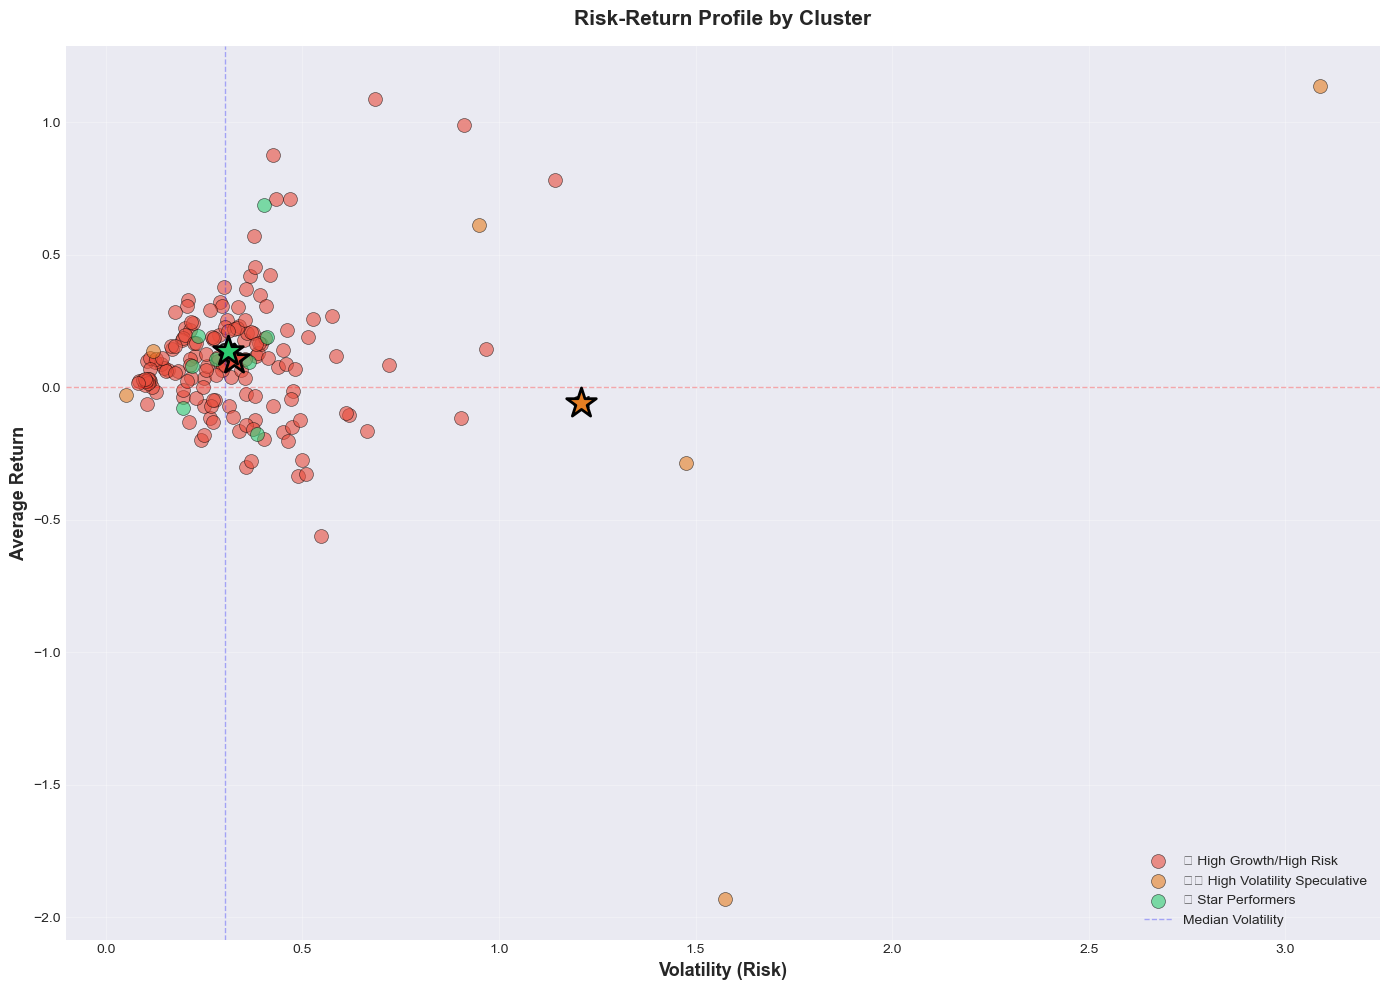

In [18]:
# Create risk-return scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

for cluster in sorted(numerical_features['Cluster'].unique()):
    cluster_data = numerical_features[numerical_features['Cluster'] == cluster]
    
    archetype = cluster_archetypes.get(cluster, {})
    color = archetype.get('color', '#999999')
    name = archetype.get('name', f'Cluster {cluster}')
    
    # Scatter plot
    ax.scatter(
        cluster_data['volatility'], cluster_data['return_mean'],
        c=color, label=name, s=100, alpha=0.6,
        edgecolors='black', linewidth=0.5
    )
    
    # Cluster center
    center_x = cluster_data['volatility'].mean()
    center_y = cluster_data['return_mean'].mean()
    ax.scatter(center_x, center_y, c=color, s=500, 
              marker='*', edgecolors='black', linewidth=2, zorder=10)
    ax.annotate(f'C{cluster}', (center_x, center_y),
               fontsize=12, fontweight='bold', ha='center', va='center')

# Reference lines
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(x=numerical_features['volatility'].median(), 
           color='blue', linestyle='--', alpha=0.3, linewidth=1,
           label='Median Volatility')

ax.set_xlabel('Volatility (Risk)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Return', fontsize=13, fontweight='bold')
ax.set_title('Risk-Return Profile by Cluster', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('07_risk_return_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

### Portfolio Profile Recommendations

In [19]:
print("\n" + "="*80)
print("PORTFOLIO ALLOCATION RECOMMENDATIONS")
print("" + "="*80 + "")
# Generate recommendations for each risk profile
for risk_level in ['conservative', 'moderate', 'aggressive']:
    allocations = suggest_optimal_allocation(risk_tolerance=risk_level)
    
    print(f"\n{risk_level.upper()} INVESTOR PROFILE")
    print(f"{'='*80}")
    
    for archetype, weight in sorted(allocations.items(), key=lambda x: x[1], reverse=True):
        if weight > 0:
            print(f"  {archetype:35s}: {weight*100:5.1f}%")



PORTFOLIO ALLOCATION RECOMMENDATIONS

CONSERVATIVE INVESTOR PROFILE
  Defensive Stable                   :  39.4%
  Star Performers                    :  38.9%
  High Growth/High Risk              :  10.1%
  Market Neutral                     :  10.1%
  Underperformers                    :   1.5%

MODERATE INVESTOR PROFILE
  Star Performers                    :  46.2%
  Defensive Stable                   :  34.0%
  High Growth/High Risk              :  15.1%
  Market Neutral                     :   3.8%
  Underperformers                    :   0.9%

AGGRESSIVE INVESTOR PROFILE
  Star Performers                    :  41.6%
  High Growth/High Risk              :  29.7%
  Defensive Stable                   :  20.8%
  Market Neutral                     :   7.9%


### Confirm Sectors exist within Dataset

In [20]:
# Check if sector data exists and merge with cluster data

if categorical_features is not None and 'sector' in categorical_features.columns:
    # Merge sector data with clustered features
    merged_df = numerical_features.reset_index()
    
    # If Ticker is not in columns but in index, reset index
    if 'Ticker' not in merged_df.columns:
        merged_df = merged_df.rename(columns={merged_df.columns[0]: 'Ticker'})
    
    # Reset index for categorical_features to access Ticker as a column
    df_sectors = categorical_features.reset_index()[['Ticker', 'sector']].rename(columns={'sector': 'Sector'})
    merged_df = merged_df.merge(df_sectors, on='Ticker', how='left')
    
    print("Sector data merged successfully!")
    print(f"Stocks with sector info: {merged_df['Sector'].notna().sum()}/{len(merged_df)}")
else:
    print("No sector data found.")

Sector data merged successfully!
Stocks with sector info: 163/163


### Grouped Graph for Sector Distribution per Cluster

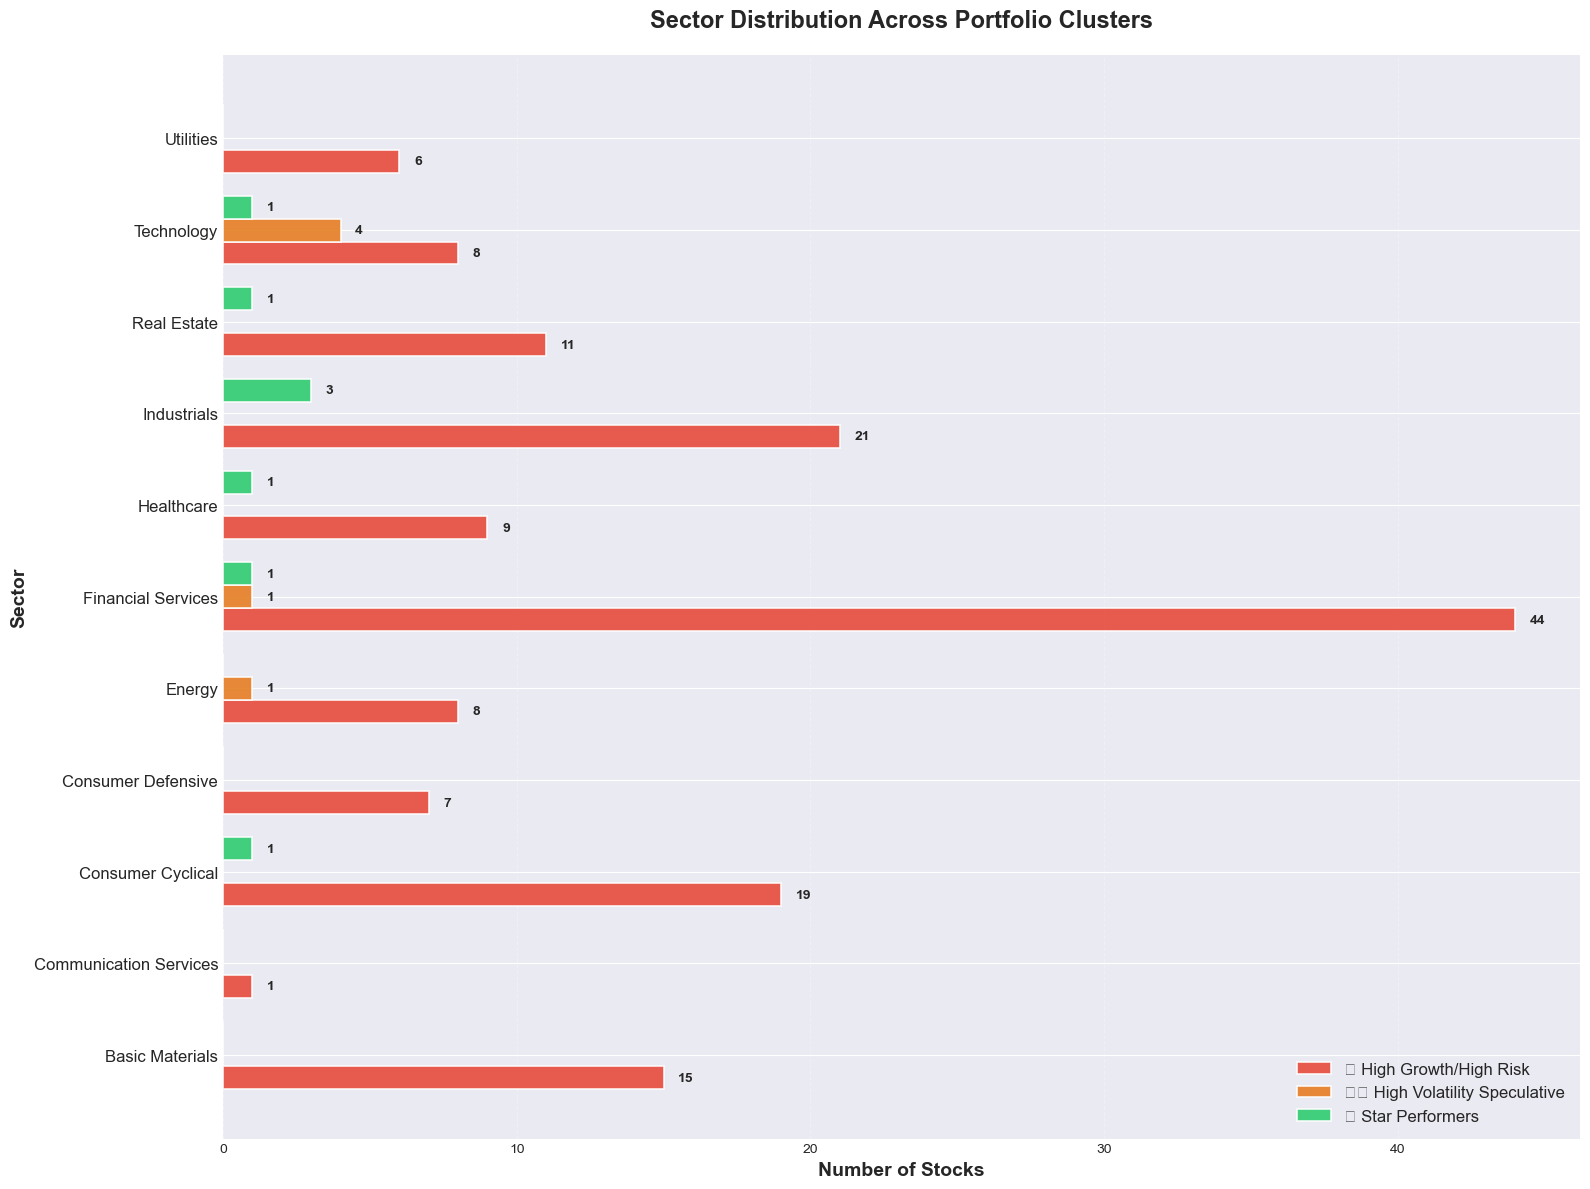

In [21]:
# Horizontal Grouped Sector Distribution
if 'Sector' in merged_df.columns:
    # Prepare data
    cluster_names = {cid: details['name'] for cid, details in cluster_archetypes.items()}
    sector_counts = pd.crosstab(merged_df['Sector'], merged_df['Cluster'])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    y = np.arange(len(sector_counts.index))
    height = 0.75 / len(sector_counts.columns)
    
    # Plot grouped bars with archetype colors
    for i, cluster in enumerate(sorted(sector_counts.columns)):
        bars = ax.barh(y + i * height, sector_counts[cluster], height,
               label=cluster_names.get(cluster, f'C{cluster}'),
               color=cluster_archetypes[cluster]['color'],
               edgecolor='white', linewidth=1.2, alpha=0.9)
        
        # Add count labels at the end of each bar
        for j, (bar, count) in enumerate(zip(bars, sector_counts[cluster])):
            if count > 0:  # Only show label if count is non-zero
                ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                       str(int(count)), 
                       va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Styling
    ax.set_ylabel('Sector', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Stocks', fontsize=14, fontweight='bold')
    ax.set_title('Sector Distribution Across Portfolio Clusters', 
                 fontsize=17, fontweight='bold', pad=20)
    ax.set_yticks(y + height * (len(sector_counts.columns) - 1) / 2)
    ax.set_yticklabels(sector_counts.index, fontsize=12)
    ax.legend(loc='lower right', framealpha=0.95, fontsize=12, edgecolor='gray')
    ax.grid(axis='x', alpha=0.25, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('08_sector_distribution_horizontal.png', dpi=300, bbox_inches='tight')
    plt.show()


### Top 3 Sector Distribution per Cluster

In [22]:
print("\n" + "="*80)
print("SECTOR DISTRIBUTION SUMMARY")
print("="*80)
for cluster in sorted(merged_df['Cluster'].unique()):
    data = merged_df[merged_df['Cluster'] == cluster]
    top_3 = data['Sector'].value_counts().head(3)
    print(f"\n{cluster_names.get(cluster, f'C{cluster}')} ({len(data)} stocks):")
    for sector, count in top_3.items():
        print(f"  • {sector}: {count} ({count/len(data)*100:.1f}%)")



SECTOR DISTRIBUTION SUMMARY

🚀 High Growth/High Risk (149 stocks):
  • Financial Services: 44 (29.5%)
  • Industrials: 21 (14.1%)
  • Consumer Cyclical: 19 (12.8%)

⚠️ High Volatility Speculative (6 stocks):
  • Technology: 4 (66.7%)
  • Energy: 1 (16.7%)
  • Financial Services: 1 (16.7%)

⭐ Star Performers (8 stocks):
  • Industrials: 3 (37.5%)
  • Real Estate: 1 (12.5%)
  • Financial Services: 1 (12.5%)


### Executive Dashboard for Business Presentation

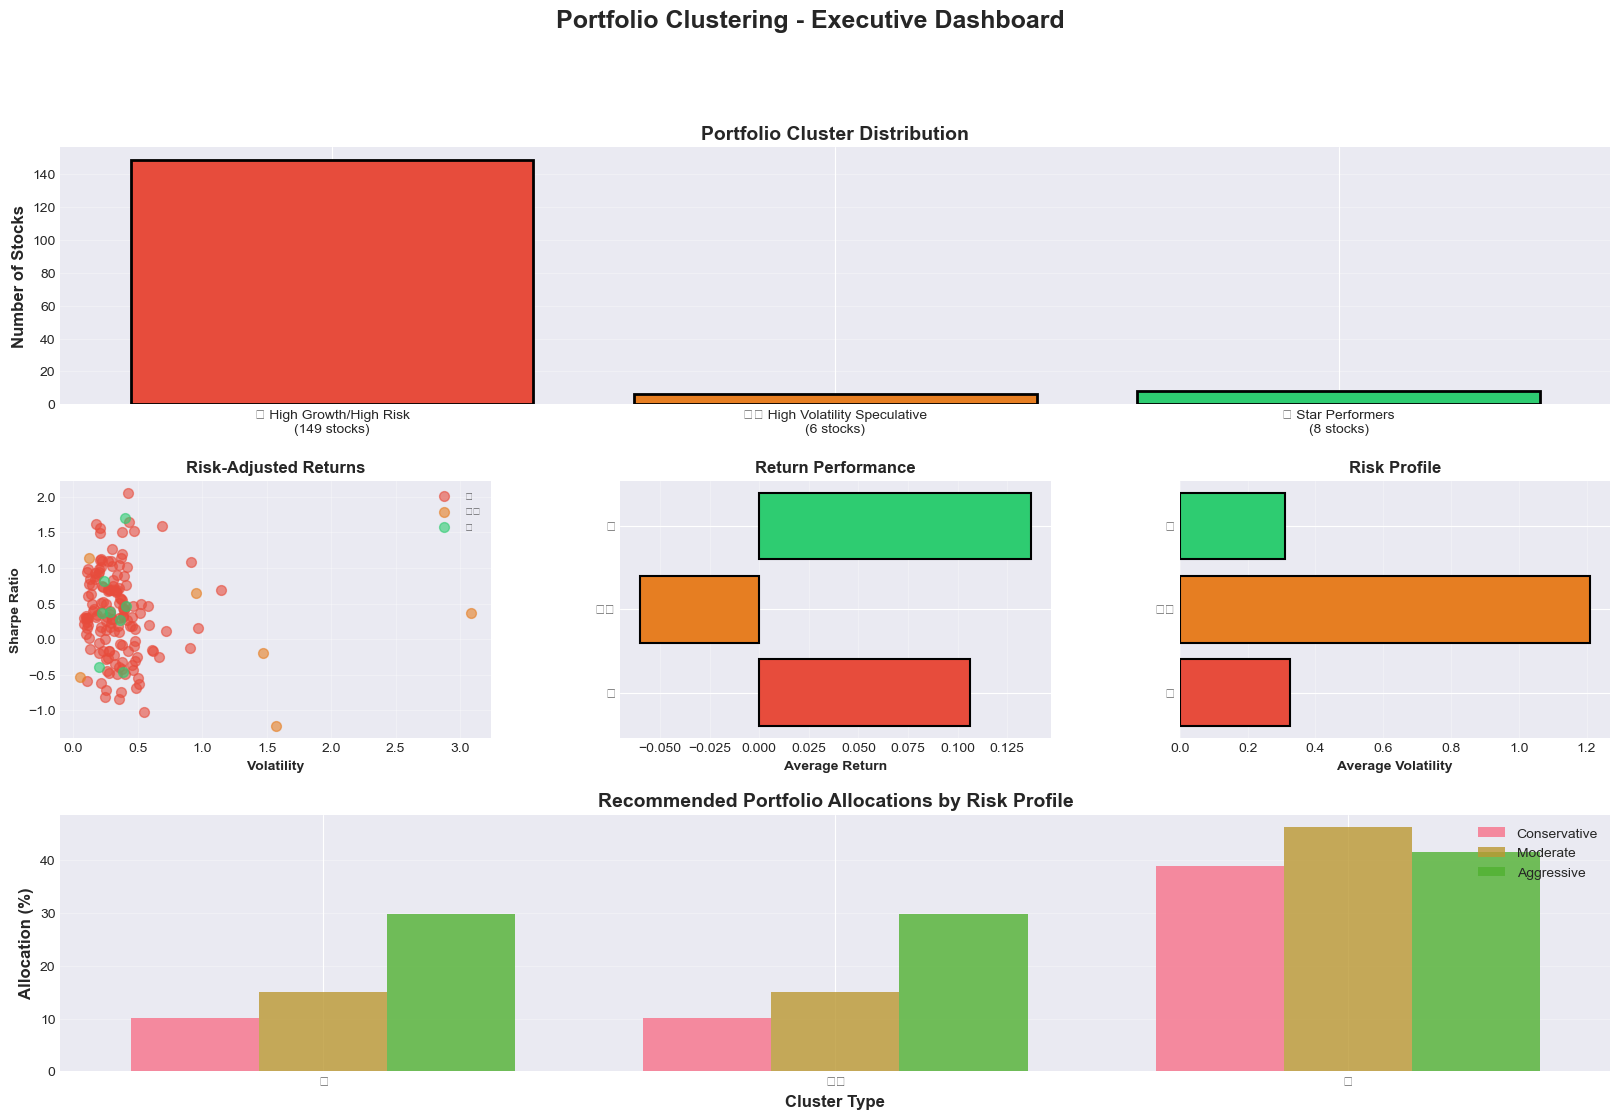

In [23]:
# Create comprehensive executive dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Top row: Cluster size distribution
ax1 = fig.add_subplot(gs[0, :])
cluster_sizes = numerical_features['Cluster'].value_counts().sort_index()
colors = [cluster_archetypes[i]['color'] for i in cluster_sizes.index]
labels = [f"{cluster_archetypes[i]['name']}\n({size} stocks)" 
          for i, size in cluster_sizes.items()]
ax1.bar(range(len(cluster_sizes)), cluster_sizes.values, color=colors, 
        edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(cluster_sizes)))
ax1.set_xticklabels(labels, fontsize=10)
ax1.set_ylabel('Number of Stocks', fontsize=12, fontweight='bold')
ax1.set_title('Portfolio Cluster Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Middle row: Risk metrics
ax2 = fig.add_subplot(gs[1, 0])
for cluster in sorted(numerical_features['Cluster'].unique()):
    data = numerical_features[numerical_features['Cluster'] == cluster]
    ax2.scatter(data['volatility'], data['sharpe'], 
               color=cluster_archetypes[cluster]['color'],
               label=cluster_archetypes[cluster]['name'].split()[0],
               s=50, alpha=0.6)
ax2.set_xlabel('Volatility', fontsize=10, fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontsize=10, fontweight='bold')
ax2.set_title('Risk-Adjusted Returns', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# Average returns by cluster
ax3 = fig.add_subplot(gs[1, 1])
avg_returns = numerical_features.groupby('Cluster')['return_mean'].mean()
colors_ret = [cluster_archetypes[i]['color'] for i in avg_returns.index]
ax3.barh(range(len(avg_returns)), avg_returns.values, color=colors_ret,
         edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(avg_returns)))
ax3.set_yticklabels([cluster_archetypes[i]['name'].split()[0] 
                      for i in avg_returns.index])
ax3.set_xlabel('Average Return', fontsize=10, fontweight='bold')
ax3.set_title('Return Performance', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Volatility comparison
ax4 = fig.add_subplot(gs[1, 2])
avg_vol = numerical_features.groupby('Cluster')['volatility'].mean()
colors_vol = [cluster_archetypes[i]['color'] for i in avg_vol.index]
ax4.barh(range(len(avg_vol)), avg_vol.values, color=colors_vol,
         edgecolor='black', linewidth=1.5)
ax4.set_yticks(range(len(avg_vol)))
ax4.set_yticklabels([cluster_archetypes[i]['name'].split()[0] 
                      for i in avg_vol.index])
ax4.set_xlabel('Average Volatility', fontsize=10, fontweight='bold')
ax4.set_title('Risk Profile', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Bottom row: Portfolio recommendations
ax5 = fig.add_subplot(gs[2, :])
risk_profiles = ['conservative', 'moderate', 'aggressive']
x_positions = np.arange(len(cluster_archetypes))
width = 0.25

for i, risk_level in enumerate(risk_profiles):
    allocations = suggest_optimal_allocation(risk_tolerance=risk_level)
    
    values = []
    for cluster_id in sorted(cluster_archetypes.keys()):
        archetype_name = cluster_archetypes[cluster_id]['name']
        alloc = 0
        for arch_name, weight in allocations.items():
            if any(keyword in archetype_name for keyword in arch_name.split()):
                alloc = weight * 100
                break
        values.append(alloc)
    
    ax5.bar(x_positions + i*width, values, width, 
            label=risk_level.capitalize(), alpha=0.8)

ax5.set_xlabel('Cluster Type', fontsize=12, fontweight='bold')
ax5.set_ylabel('Allocation (%)', fontsize=12, fontweight='bold')
ax5.set_title('Recommended Portfolio Allocations by Risk Profile', 
              fontsize=14, fontweight='bold')
ax5.set_xticks(x_positions + width)
ax5.set_xticklabels([cluster_archetypes[i]['name'].split()[0] 
                      for i in sorted(cluster_archetypes.keys())], rotation=0)
ax5.legend(fontsize=10, loc='upper right')
ax5.grid(axis='y', alpha=0.3)

plt.suptitle('Portfolio Clustering - Executive Dashboard', 
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('09_executive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

### Top Five Performing Stocks per Cluster (Sharpe Ratio)

In [24]:
print("\n" + "="*80)
print("TOP PERFORMING STOCKS PER CLUSTER (by Sharpe Ratio)")
print("="*80)

for cluster_id in sorted(numerical_features['Cluster'].unique()):
    cluster_data = numerical_features[numerical_features['Cluster'] == cluster_id]
    
    # Sort by Sharpe ratio and get top 5
    top_stocks = cluster_data.nlargest(5, 'sharpe')
    
    print(f"\n{cluster_archetypes[cluster_id]['name']}:")
    print("-" * 80)
    
    for idx, row in top_stocks.iterrows():
        ticker = idx if isinstance(idx, str) else idx[0] if isinstance(idx, tuple) else str(idx)
        print(f"  {ticker:10s} | Return: {row['return_mean']:7.4f} | "
              f"Volatility: {row['volatility']:7.4f} | "
              f"Sharpe: {row['sharpe']:7.4f}")


TOP PERFORMING STOCKS PER CLUSTER (by Sharpe Ratio)

🚀 High Growth/High Risk:
--------------------------------------------------------------------------------
  KGC        | Return:  0.8773 | Volatility:  0.4263 | Sharpe:  2.0577
  MTZ        | Return:  0.7112 | Volatility:  0.4333 | Sharpe:  1.6413
  TJX        | Return:  0.2853 | Volatility:  0.1758 | Sharpe:  1.6227
  COE        | Return:  1.0862 | Volatility:  0.6845 | Sharpe:  1.5870
  BTI        | Return:  0.3275 | Volatility:  0.2091 | Sharpe:  1.5664

⚠️ High Volatility Speculative:
--------------------------------------------------------------------------------
  SEMG       | Return:  0.1379 | Volatility:  0.1204 | Sharpe:  1.1451
  FENG       | Return:  0.6111 | Volatility:  0.9488 | Sharpe:  0.6441
  STI        | Return:  1.1353 | Volatility:  3.0886 | Sharpe:  0.3676
  SQNS       | Return: -0.2876 | Volatility:  1.4744 | Sharpe: -0.1951
  SMI        | Return: -0.0274 | Volatility:  0.0507 | Sharpe: -0.5408

⭐ Star Performe

### Final Stock Details

In [25]:
stock_details = numerical_features.reset_index()

# Add cluster names
stock_details['Cluster_Name'] = stock_details['Cluster'].map(
    {cid: details['archetype']['name'] 
     for cid, details in business_report['cluster_details'].items()}
)

# Add sector if available
if 'merged_df' in locals() and 'Sector' in merged_df.columns:
    if 'Ticker' not in stock_details.columns and stock_details.columns[0] != 'Ticker':
        stock_details = stock_details.rename(columns={stock_details.columns[0]: 'Ticker'})
    stock_details = stock_details.merge(
        merged_df[['Ticker', 'Sector']], 
        on='Ticker', 
        how='left'
    )

stock_details.to_excel('10_Final_Stock_Details.xlsx', index=False)